# Glioma Demo − Radiomic Computations

@Author : [MEDomics consortium](https://github.com/medomics/)

@EMAIL : medomics.info@gmail.com

**STATEMENT**:
This file is part of <https://github.com/MEDomics/MEDomicsLab/>,
a package providing PYTHON programming tools for radiomics analysis.
--> Copyright (C) MEDomicsLab consortium.

## Introduction

We assume that you now understand the usage of most parts of the package. If that's not the case, we invite you to take a look at the available tutorials [here](https://medimage.readthedocs.io/en/latest/tutorials.html).

This is a final notebook that demonstrates the usage of the ``MEDimage`` package for one scan. It is a final demo that shows in a brief way the flexibility and the versatility of the code in radiomics analysis. We will use a **[glioma TCGA](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga)** cancer scan.

**Extra**: This notebook also demonstrates an extra feature of ``MEDimage`` which is mask cropping (ROI boxing)  that could be useful for running radiomics analysis with a scan box around the ROI only instead of the full scan.


## Dataset - Glioma TCGA MR image

We are using an MRI scan, which is provided in the repository:

Information about our scan:
 - **ID**: Glioma-TCGA-02-003
 - **Imaging scan name**: T1
 - **Modality**: MRscan
 - **Regions of interest**:
     - Number of regions: 6
     - Names of ROIs: ED, ET, NET, ED_M, ET_M and NET_M
     - ROI name: {ED}+{ET}+{NET}

In [1]:
import os
import sys
from pathlib import Path

MODULE_DIR = os.path.dirname(os.path.abspath('../MEDimage/'))
sys.path.append(os.path.dirname(MODULE_DIR))

import MEDimage
import numpy as np

## Initialization

Initializing ``MEDscan`` class by loading an existent pickle object (instance of the class) saved locally.

In [2]:
import pickle

path_data = Path(os.getcwd()) / 'data' / 'Glioma-TCGA-02-0003__T1.MRscan.npy'
with open(path_data, 'rb') as f: medscan = pickle.load(f)
medscan = MEDimage.MEDscan(medscan)

As explained in other tutorials, the parameter initialization uses a Dictionary and ``MEDscan`` class method ``init_params`` that takes the dict as an input argument and organize all parameters in class attributes which make them easy to manipulate. But you can skip this part and hard-code your parameters for each method which is the case for this demo.

## Features extraction demonstration

As always, the first step in radiomics analysis to create the ROI (region of interest)

In [3]:
vol_obj_init, roi_obj_init = MEDimage.processing.get_roi_from_indexes(
            medscan,
            name_roi='{ED}+{ET}+{NET}',
            box_string='full')

Some features do not need any pre-processing and can be extracted directly from imaging data like:
- Local intensity features extraction

In [4]:
local_intensity = MEDimage.biomarkers.local_intensity.extract_all(
                img_obj=vol_obj_init.data,
                roi_obj=roi_obj_init.data,
                res=[2, 2, 3]
            )

You can also compute certain features from every feature family instead of extarcting all of them just by specifying its name. For example in the local intensity family we can extarct the local intensity peak feature only by running:

In [5]:
local_intensity_peak = MEDimage.biomarkers.local_intensity.peak_local(
                img_obj=vol_obj_init.data,
                roi_obj=roi_obj_init.data,
                res=[2, 2, 3]
            )

- Interpolation: Use subpackage ``processing`` and method ``interp_volume``

In [6]:
# Interpolation
# Intensity Mask
vol_obj = MEDimage.processing.interp_volume(
    vol_obj_s=vol_obj_init,
    roi_obj_s=roi_obj_init,
    vox_dim=[2, 2, 3],
    interp_met="linear",
    round_val=[],
    image_type="image",
    box_string="full"
)
# Morphological Mask
roi_obj_morph = MEDimage.processing.interp_volume(
    vol_obj_s=roi_obj_init,
    roi_obj_s=roi_obj_init,
    vox_dim=[2, 2, 3],
    interp_met="linear",
    round_val=0.5,
    image_type="roi",
    box_string="full"
)

- Re-segmentation: 
    - Range re-segmentation: Use subpackage ``processing`` and method ``range_re_seg``
    - Outlier re-segmentation: Use subpackage ``processing`` and method ``outlier_re_seg``

In [7]:
from copy import deepcopy

# Re-segmentation
# Intensity mask range re-segmentation
roi_obj_int = deepcopy(roi_obj_morph)
roi_obj_int.data = MEDimage.processing.range_re_seg(
    vol=vol_obj.data, 
    roi=roi_obj_int.data,
    im_range=[-500, 400]
)
# Intensity mask outlier re-segmentation
roi_obj_int.data = np.logical_and(
    MEDimage.processing.outlier_re_seg(
        vol=vol_obj.data, 
        roi=roi_obj_int.data, 
        outliers=''
    ),
    roi_obj_int.data
).astype(int)

- ROI extraction: Use subpackage ``processing`` and method ``roi_extract``

In [8]:
vol_int_re = MEDimage.processing.roi_extract(
    vol=vol_obj.data, 
    roi=roi_obj_int.data
)

- Statistical features extraction: Use subpackage ``biomarkers``, module ``stats`` and method ``extract_all``

In [9]:
stats = MEDimage.biomarkers.stats.extract_all(vol=vol_int_re)

- Texture features extraction: 
    - GLCM (Grey level co-occurrence matrix based features): Use subpackage ``biomarkers``, module ``glcm`` and method ``extract_all``

In [10]:
glcm = MEDimage.biomarkers.glcm.extract_all(
        vol=vol_int_re, 
        dist_correction=False
    )
glcm

{'Fcm_joint_max': 0.0016778523489932886,
 'Fcm_joint_avg': 372.03796140939596,
 'Fcm_joint_var': 923.214792152873,
 'Fcm_joint_entr': 10.21245711106619,
 'Fcm_diff_avg': 21.386325503355707,
 'Fcm_diff_var': 786.4581351557925,
 'Fcm_diff_entr': 7.965902141630304,
 'Fcm_sum_avg': 744.0759228187919,
 'Fcm_sum_var': 2449.0261149202174,
 'Fcm_sum_entr': 8.683223590927662,
 'Fcm_energy': 0.0008445565515066891,
 'Fcm_contrast': 1243.8330536912752,
 'Fcm_dissimilarity': 21.386325503355703,
 'Fcm_inv_diff': 0.1340401104247356,
 'Fcm_inv_diff_norm': 0.9166501446905972,
 'Fcm_inv_diff_mom': 0.0687299658265903,
 'Fcm_inv_diff_mom_norm': 0.9771808043523809,
 'Fcm_inv_var': 0.35790780102435327,
 'Fcm_corr': 0.32635770989395946,
 'Fcm_auto_corr': 138713.54299496644,
 'Fcm_clust_tend': 2449.0261149202174,
 'Fcm_clust_shade': -201810.43509673234,
 'Fcm_clust_prom': 41649414.51934898,
 'Fcm_info_corr1': -0.5891829704064108,
 'Fcm_info_corr2': 0.9999012496088444}

- Texture features single-extraction: 
    - GLCM (Grey level co-occurrence matrix based features): As mentioned before, you can extract features of your choice from any features family just by using their name, but this process is different for matrix-based features because the matrix needs to be computed before extracting the selected features in order to avoid repeated calculation of the matrix. Here is an example for GLCM:

In [11]:
# Computation of GLCM matrix
glc_matrix = MEDimage.biomarkers.glcm.get_glcm_matrices(vol_int_re)
# Extraction of joint maximum feature
joint_max = MEDimage.biomarkers.glcm.joint_max(glc_matrix)
# Extraction of joint average feature
joint_avg = MEDimage.biomarkers.glcm.joint_avg(glc_matrix)
joint_max, joint_avg

(0.0016778523489932886, 372.03796140939596)

And logically we should have the same values whether we have used single extraction or family extraction. In a nutshell, processing and features extraction are pretty easy, just make sure you use the correct arguments and respect the order of the radiomics pipeline.

## Features extraction from filtered image

The filters subpackage offers a useful tool for medical image filtering with a family of commonly used filters for the radiomics analysis. the following example, shows image filtering using ``Laws`` filter.

In [12]:
vol_obj = MEDimage.filters.apply_laws(
                        input_images=vol_obj,
                        config=["E3", "W5", "R5"],
                        padding="symmetric",
                        rot_invariance=False,
                        energy_image=False)

We now have our new filtered image and we can use it to compute any radiomic feature as we do for any other data.

In [13]:
peak_local_intensity = MEDimage.biomarkers.local_intensity.peak_local(
                img_obj=vol_obj.data,
                roi_obj=vol_obj.data,
                res=[2, 2, 3]
            )
peak_local_intensity

1.08767087954325

## Image & Mask cropping - Box creation

In this section we will demonstrate how you can crop the image & the mask and generate a bounding box centered around the ROI with a specific cropping shape. This can be done using the method *crop_box()* in the processing sub-module. A cropped box serves the same purposes as the full imaging volume.

Visualize imaging data before cropping

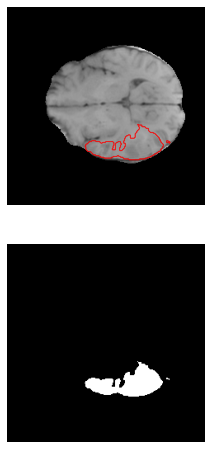

In [14]:
import matplotlib.pyplot as plt


_slice = 65 # index of slice that will be plotted
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.axis('off')
plt.imshow(vol_obj_init.data[:, :, _slice], cmap='gray')
plt.contour(roi_obj_init.data[:, :, _slice], colors='red', linewidths=0.4, origin='lower', alpha=0.5)
plt.subplot(2, 1, 2)
plt.axis('off')
plt.imshow(roi_obj_init.data[:, :, _slice], cmap='gray')
plt.show()

Let's now specify the cropping shape and call the cropping method. You can use *compute_bounding_box* method in *processing* module to help you decide the shape of the box.

In [15]:
# crop the initial imaging data
crop_shape = [56, 122, 82] # All elements of crop_shape must be an even number (in voxels not in mm)
new_image, new_roi = MEDimage.processing.crop_box(vol_obj_init.data, roi_obj_init.data, crop_shape)

Visualize the cropped box

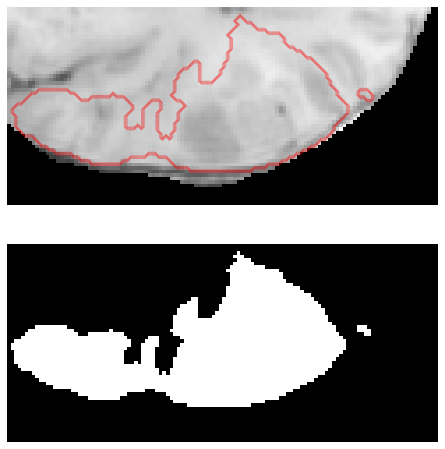

In [16]:
_slice = 30 # index of slice that will be plotted
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.axis('off')
plt.imshow(new_image[:, :, _slice], cmap='gray')
plt.contour(new_roi[:, :, _slice], colors='red', linewidths=0.4, origin='lower', alpha=0.5)
plt.subplot(2, 1, 2)
plt.axis('off')
plt.imshow(new_roi[:, :, _slice], cmap='gray')
plt.show()

## Bonus: using the cropped box to compute radiomics

The created box can serve for the same purposes as the full image volume, as long as the full ROI is included in the cropped box (by choosing the right crop shape). Without processing, let's try to extract some basic features.

Update the imaging and mask data with the new cropped data

In [17]:
local_intensity_peak_cropped = MEDimage.biomarkers.local_intensity.peak_local(
                img_obj=vol_obj_init.data,
                roi_obj=roi_obj_init.data,
                res=[2, 2, 3]
            )

And we should get the same results!

In [18]:
local_intensity_peak, local_intensity_peak_cropped

(834.9589, 834.9589)

## Conclusion

This final demo shows how flexible the ``MEDimage`` package can be which makes it a useful tool for reproducible image processing and features extraction.